<a href="https://colab.research.google.com/github/mikalajjjj/Data-Mining-Animal_Shelter/blob/main/AACOutcomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification: Austin Animal Center Outcomes
- Intro to Data Mining CS 363D
- Project Group 46

Can we predict whether an animal in the Austin Animal Center will be adopted, transfered, or euthanized? Here, we perform multi-class classification on an animal's `Outcome Type`, using features from the [Austin Animal Center Intakes dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm). The class label (`Outcome Type`) is from the [Animal Center Outcomes dataset](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238); these data sets are joined on `Animal ID`.


In [1]:
%pip install pandas
%pip install scikit-learn

In [2]:
!curl -o intakes.csv "https://data.austintexas.gov/api/views/wter-evkm/rows.csv?accessType=DOWNLOAD"
!curl -o outcomes.csv "https://data.austintexas.gov/api/views/9t4d-g238/rows.csv?accessType=DOWNLOAD"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.7M    0 24.7M    0     0  2172k      0 --:--:--  0:00:11 --:--:-- 1921k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.3M    0 20.3M    0     0   884k      0 --:--:--  0:00:23 --:--:-- 1004k


In [3]:
import pandas as pd
import sklearn as sk

## Data Prep

- We join the 2 datasets: Intakes and Outcomes on their common column `Animal ID`.
- Some Animal IDs have multiple intakes/outcomes.
    - Number the duplicates (based on DateTime).
    - Pair intakes and outcomes based on Animal ID and Duplicate Number.

In [4]:
intakes = pd.read_csv("intakes.csv")
intakes["DateTime"] = pd.to_datetime(intakes["DateTime"])
intakes.sort_values(by="DateTime", inplace=True) # sort by date
intakes['Duplicate Number'] = intakes.groupby(['Animal ID']).cumcount() # Mark duplicate entries

# Age upon Intake: translate into Age upon Intake_NumYearsOld
def getNumYearsOld(age_str):
    months_in_a_year = 12
    weeks_in_a_year = 52.143
    days_in_a_year = 365.25
    year_idx = age_str.find("year")-1
    if(year_idx >= 0):
        return float(age_str[:year_idx])
    month_idx = age_str.find("month")-1
    if(month_idx >= 0):
        return float(age_str[:month_idx])/months_in_a_year
    weeks_idx = age_str.find("week")-1
    if(weeks_idx >= 0):
        return float(age_str[:weeks_idx])/weeks_in_a_year
    days_idx = age_str.find("day")-1
    if(days_idx >= 0):
        return float(age_str[:days_idx])/days_in_a_year
    return None

intakes["Age upon Intake"] = intakes["Age upon Intake"].apply(getNumYearsOld) # make age in terms of yearas

print(intakes.shape)
intakes.head()

(173812, 13)


,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Duplicate Number
0,A521520,Nina,2013-10-01 07:51:00,October 2013,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7.000000,Border Terrier/Border Collie,White/Tan,0
1,A664235,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,0.019178,Domestic Shorthair Mix,Orange/White,0
2,A664236,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,0.019178,Domestic Shorthair Mix,Orange/White,0
3,A664237,NaN,2013-10-01 08:33:00,October 2013,Abia in Austin (TX),Stray,Normal,Cat,Unknown,0.019178,Domestic Shorthair Mix,Orange/White,0
4,A664233,Stevie,2013-10-01 08:53:00,October 2013,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3.000000,Pit Bull Mix,Blue/White,0


In [8]:
outcomes = pd.read_csv("outcomes.csv")
outcomes["DateTime"] = pd.to_datetime(outcomes["DateTime"], format='mixed', utc=True)
outcomes.sort_values(by="DateTime", inplace=True)
outcomes['Duplicate Number'] = outcomes.groupby(['Animal ID']).cumcount() # Mark duplicate entries
print(outcomes.shape)
outcomes.head()

(173775, 13)


,Animal ID,Date of Birth,Name,DateTime,MonthYear,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Duplicate Number
2371,A659834,2013-07-23,*Dudley,2013-10-01 09:31:00+00:00,10-2013,Adoption,Foster,Dog,Neutered Male,2 months,Labrador Retriever Mix,Black,0
2372,A664235,2013-09-24,NaN,2013-10-01 10:39:00+00:00,10-2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,0
2374,A664237,2013-09-24,NaN,2013-10-01 10:44:00+00:00,10-2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,0
2373,A664236,2013-09-24,NaN,2013-10-01 10:44:00+00:00,10-2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,0
2375,A664223,2009-09-30,Moby,2013-10-01 11:03:00+00:00,10-2013,Return to Owner,NaN,Dog,Neutered Male,4 years,Bulldog Mix,White,0


In [9]:
outcomes_label = outcomes[["Animal ID", "Duplicate Number", "DateTime", "Outcome Type"]]
outcomes_label = outcomes_label.rename(columns={"DateTime": "DateTime_Outcome"})
print(outcomes_label.shape)
outcomes_label.head()

(173775, 4)


,Animal ID,Duplicate Number,DateTime_Outcome,Outcome Type
2371,A659834,0,2013-10-01 09:31:00+00:00,Adoption
2372,A664235,0,2013-10-01 10:39:00+00:00,Transfer
2374,A664237,0,2013-10-01 10:44:00+00:00,Transfer
2373,A664236,0,2013-10-01 10:44:00+00:00,Transfer
2375,A664223,0,2013-10-01 11:03:00+00:00,Return to Owner


In [10]:
raw_df = intakes.merge(outcomes_label, on=["Animal ID", "Duplicate Number"], how="inner").set_index("Animal ID")
raw_df.sort_values(by=["Animal ID", "Duplicate Number"], inplace=True)
raw_df.head()

# "Scamp" has 3 intakes/outcomes (all resulting in "Return to Owner"). They are paired together correctly!

,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Duplicate Number,DateTime_Outcome,Outcome Type
Animal ID,,,,,,,,,,,,,,
A006100,Scamp,2014-03-07 14:26:00,March 2014,8700 Research in Austin (TX),Public Assist,Normal,Dog,Neutered Male,6.0,Spinone Italiano Mix,Yellow/White,0,2014-03-08 17:10:00+00:00,Return to Owner
A006100,Scamp,2014-12-19 10:21:00,December 2014,8700 Research Blvd in Austin (TX),Public Assist,Normal,Dog,Neutered Male,7.0,Spinone Italiano Mix,Yellow/White,1,2014-12-20 16:35:00+00:00,Return to Owner
A006100,Scamp,2017-12-07 14:07:00,December 2017,Colony Creek And Hunters Trace in Austin (TX),Stray,Normal,Dog,Neutered Male,10.0,Spinone Italiano Mix,Yellow/White,2,2017-12-07 05:00:00+00:00,Return to Owner
A047759,Oreo,2014-04-02 15:55:00,April 2014,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,10.0,Dachshund,Tricolor,0,2014-04-07 15:12:00+00:00,Transfer
A134067,Bandit,2013-11-16 09:02:00,November 2013,12034 Research Blvd in Austin (TX),Public Assist,Injured,Dog,Neutered Male,16.0,Shetland Sheepdog,Brown/White,0,2013-11-16 11:54:00+00:00,Return to Owner


In [11]:
raw_df.index = raw_df.index.map(str) + "_" + raw_df['Duplicate Number'].map(str)
raw_df = raw_df.drop(columns=["DateTime_Outcome", "Duplicate Number"])
raw_df.index.name = 'Animal ID'



raw_df.to_csv("raw_full_dataset.csv")
print(raw_df.shape)
raw_df.head()

(172850, 12)


,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Outcome Type
Animal ID,,,,,,,,,,,,
A006100_0,Scamp,2014-03-07 14:26:00,March 2014,8700 Research in Austin (TX),Public Assist,Normal,Dog,Neutered Male,6.0,Spinone Italiano Mix,Yellow/White,Return to Owner
A006100_1,Scamp,2014-12-19 10:21:00,December 2014,8700 Research Blvd in Austin (TX),Public Assist,Normal,Dog,Neutered Male,7.0,Spinone Italiano Mix,Yellow/White,Return to Owner
A006100_2,Scamp,2017-12-07 14:07:00,December 2017,Colony Creek And Hunters Trace in Austin (TX),Stray,Normal,Dog,Neutered Male,10.0,Spinone Italiano Mix,Yellow/White,Return to Owner
A047759_0,Oreo,2014-04-02 15:55:00,April 2014,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,10.0,Dachshund,Tricolor,Transfer
A134067_0,Bandit,2013-11-16 09:02:00,November 2013,12034 Research Blvd in Austin (TX),Public Assist,Injured,Dog,Neutered Male,16.0,Shetland Sheepdog,Brown/White,Return to Owner


## Data Exploration

In [14]:
raw_df.describe(include="all")
# don't have a name?
# datetime as timedelta - visualize datetime

,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Outcome Type
count,123135,172850,172850,172850,172850,172850,172850,172849,172850.000000,172850,172850,172804
unique,29674,NaN,140,69887,6,20,5,5,NaN,3002,660,11
top,Luna,NaN,June 2015,Austin (TX),Stray,Normal,Dog,Intact Male,NaN,Domestic Shorthair Mix,Black/White,Adoption
freq,758,NaN,2189,31374,118514,146436,94054,58645,NaN,33659,17885,83998
mean,NaN,2018-11-17 17:03:12.657795584,NaN,NaN,NaN,NaN,NaN,NaN,1.937496,NaN,NaN,NaN
min,NaN,2013-10-01 07:51:00,NaN,NaN,NaN,NaN,NaN,NaN,-4.000000,NaN,NaN,NaN
25%,NaN,2016-02-13 14:21:30,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,NaN
50%,NaN,2018-07-23 16:48:00,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
75%,NaN,2021-08-06 16:05:00,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN
max,NaN,2025-05-04 13:15:00,NaN,NaN,NaN,NaN,NaN,NaN,30.000000,NaN,NaN,NaN


In [15]:
raw_df["Outcome Type"].value_counts()

,count
Outcome Type,
Adoption,83998
Transfer,48472
Return to Owner,25633
Euthanasia,10793
Died,1664
Rto-Adopt,1241
Disposal,877
Missing,91
Relocate,28


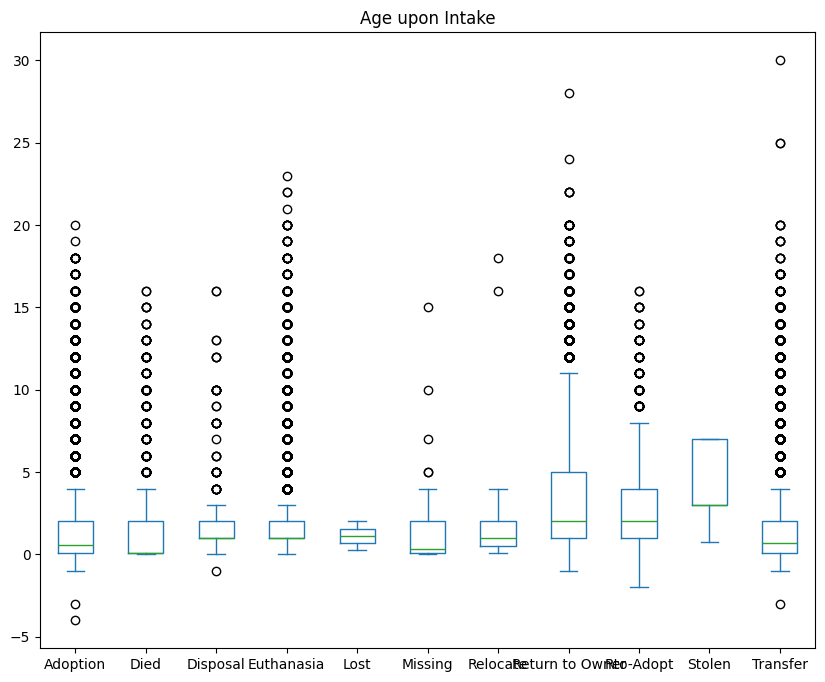

In [16]:
#plot = raw_df.loc[raw_df['Outcome Type'] == "Euthanasia"].plot.pie(y='', figsize=(5, 5))

ax = raw_df.plot.box(column="Age upon Intake", by="Outcome Type", figsize=(10, 8))


['Domestic Shorthair', 'Pit Bull', 'Labrador Retriever', 'Chihuahua Shorthair', 'German Shepherd', 'Domestic Medium Hair', 'Bat', 'Australian Cattle Dog', 'Domestic Longhair', 'Siamese', 'Siberian Husky']
Adoption
Breed
Domestic Shorthair       29262
Other                    27297
Pit Bull                  6054
Labrador Retriever        5920
Chihuahua Shorthair       4245
German Shepherd           3338
Domestic Medium Hair      2961
Australian Cattle Dog     1512
Domestic Longhair         1337
Siamese                   1080
Siberian Husky             992
Name: count, dtype: int64
Died
Breed
Domestic Shorthair       833
Other                    365
Bat                      115
Domestic Medium Hair      83
Chihuahua Shorthair       63
Labrador Retriever        52
Pit Bull                  49
Domestic Longhair         35
Siamese                   27
German Shepherd           23
Australian Cattle Dog     10
Siberian Husky             9
Name: count, dtype: int64
Disposal
Breed
Bat          

/tmp/ipython-input-3728107877.py:35: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  outcome_groups = [gb.get_group(x) for x in gb.groups]


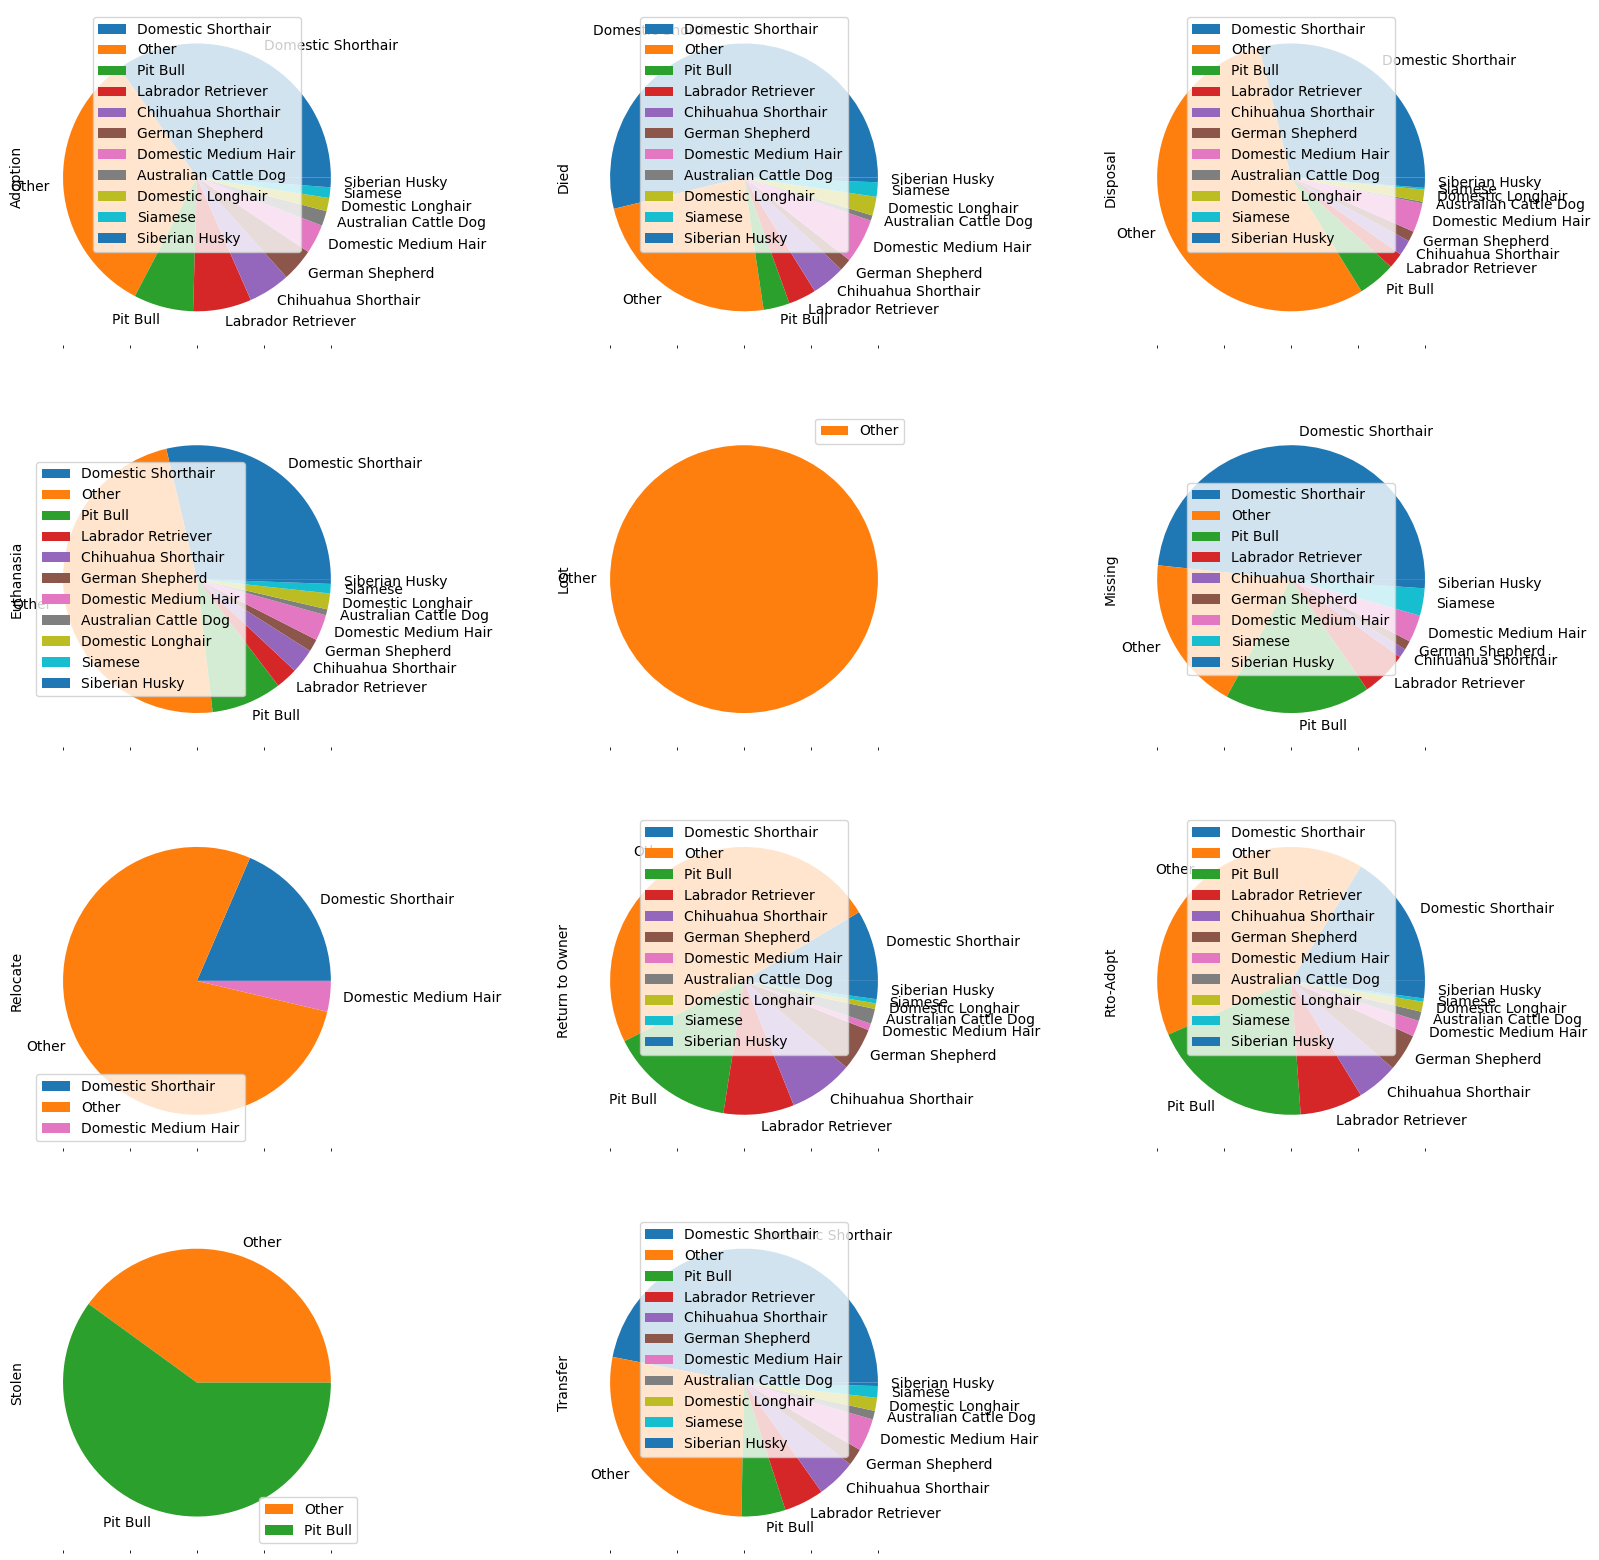

In [20]:
from matplotlib import pyplot as plt

def cumulatively_categorize(df, columns, threshold_freq = .9, num_categories = None):
    '''
    Only keep categories needed sum to threshold_freq, move rest into "Other".
    Or, keep top threshold_num categories, and move rest into "Other".
    '''
    df = df.copy()
    # Calculate the threshold based on frequency or number of categories
    threshold = threshold_freq*len(df)
    for column_name in columns:

        # Get the value counts for the current column
        counts = df[column_name].value_counts()

        s = 0
        to_keep = []
        # Iterate through categories and their counts
        for value, count in counts.items():
            s += count
            to_keep.append(value)

            if(num_categories is not None):
                # If num_categories is specified, keep the top N categories
                if(len(to_keep) > num_categories):
                    break
            else:
                # If threshold_freq is specified, keep categories until the threshold is reached
                if(s > threshold):
                    break

        # Print the categories that will be kept
        print(to_keep)
        # Replace categories not in to_keep with 'Other'
        df[column_name]=df[column_name].apply(lambda x: x if x in to_keep else 'Other')
    return df

def show_pie_chart(df, categorical_var, label = "Outcome Type"):
    # Group the DataFrame by the specified label (default is 'Outcome Type')
    gb = df.groupby([label])
    # Get the groups and their labels
    outcome_groups = [gb.get_group(x) for x in gb.groups]
    outcome_labels = [x for x in gb.groups]

    # Create an empty DataFrame to store value counts for pie charts
    pie_chart_df = pd.DataFrame()

    # Iterate through each outcome group
    for i, outcome_df in enumerate(outcome_groups):
        # Get value counts for the categorical variable within the current outcome group
        val_counts = outcome_df[categorical_var].value_counts()
        print(outcome_labels[i])
        print(val_counts)
        # Add the value counts as a column to the pie_chart_df
        pie_chart_df[outcome_labels[i]] = val_counts # this logic is wrong: where does "Bat" go?
        # Idea: insert empty column with every Breed category, then drop it at the end.

    # Display the pie_chart_df (contains value counts for each category within each outcome type)
    pie_chart_df

    print(pie_chart_df)

    # Plot pie charts for each column in pie_chart_df
    pie_chart_df.plot.pie(subplots=True, layout=(4,3), figsize=(20, 20)) # TODO: fix the size, make pretty

# Create a copy of the raw DataFrame
df = raw_df.copy()
# Remove " Mix" from the 'Breed' column
df['Breed'] = df['Breed'].apply(lambda str: str.replace(" Mix", "")) # remove Mix

# Cumulatively categorize the 'Breed' column and then show pie charts based on 'Breed' and 'Outcome Type'
show_pie_chart(cumulatively_categorize(df, columns=["Breed"], num_categories=10), "Breed")

['Domestic Shorthair', 'Pit Bull', 'Labrador Retriever', 'Chihuahua Shorthair', 'German Shepherd', 'Domestic Medium Hair', 'Bat', 'Australian Cattle Dog', 'Domestic Longhair', 'Siamese', 'Siberian Husky']
Adoption
Intake Condition
Normal        76509
Injured        3291
Sick           1845
Nursing        1132
Neonatal        503
Medical         270
Other           141
Aged            121
Pregnant         62
Feral            39
Behavior         32
Med Attn         28
Unknown          22
Neurologic        2
Med Urgent        1
Name: count, dtype: int64
Died
Intake Condition
Normal        855
Injured       330
Sick          269
Nursing       120
Neonatal       57
Medical        13
Aged            6
Other           5
Med Attn        3
Med Urgent      2
Feral           2
Pregnant        1
Agonal          1
Name: count, dtype: int64
Disposal
Intake Condition
Normal        414
Injured       228
Sick          202
Neonatal       12
Medical         6
Pregnant        6
Nursing         4
Other    

/tmp/ipython-input-3728107877.py:35: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  outcome_groups = [gb.get_group(x) for x in gb.groups]


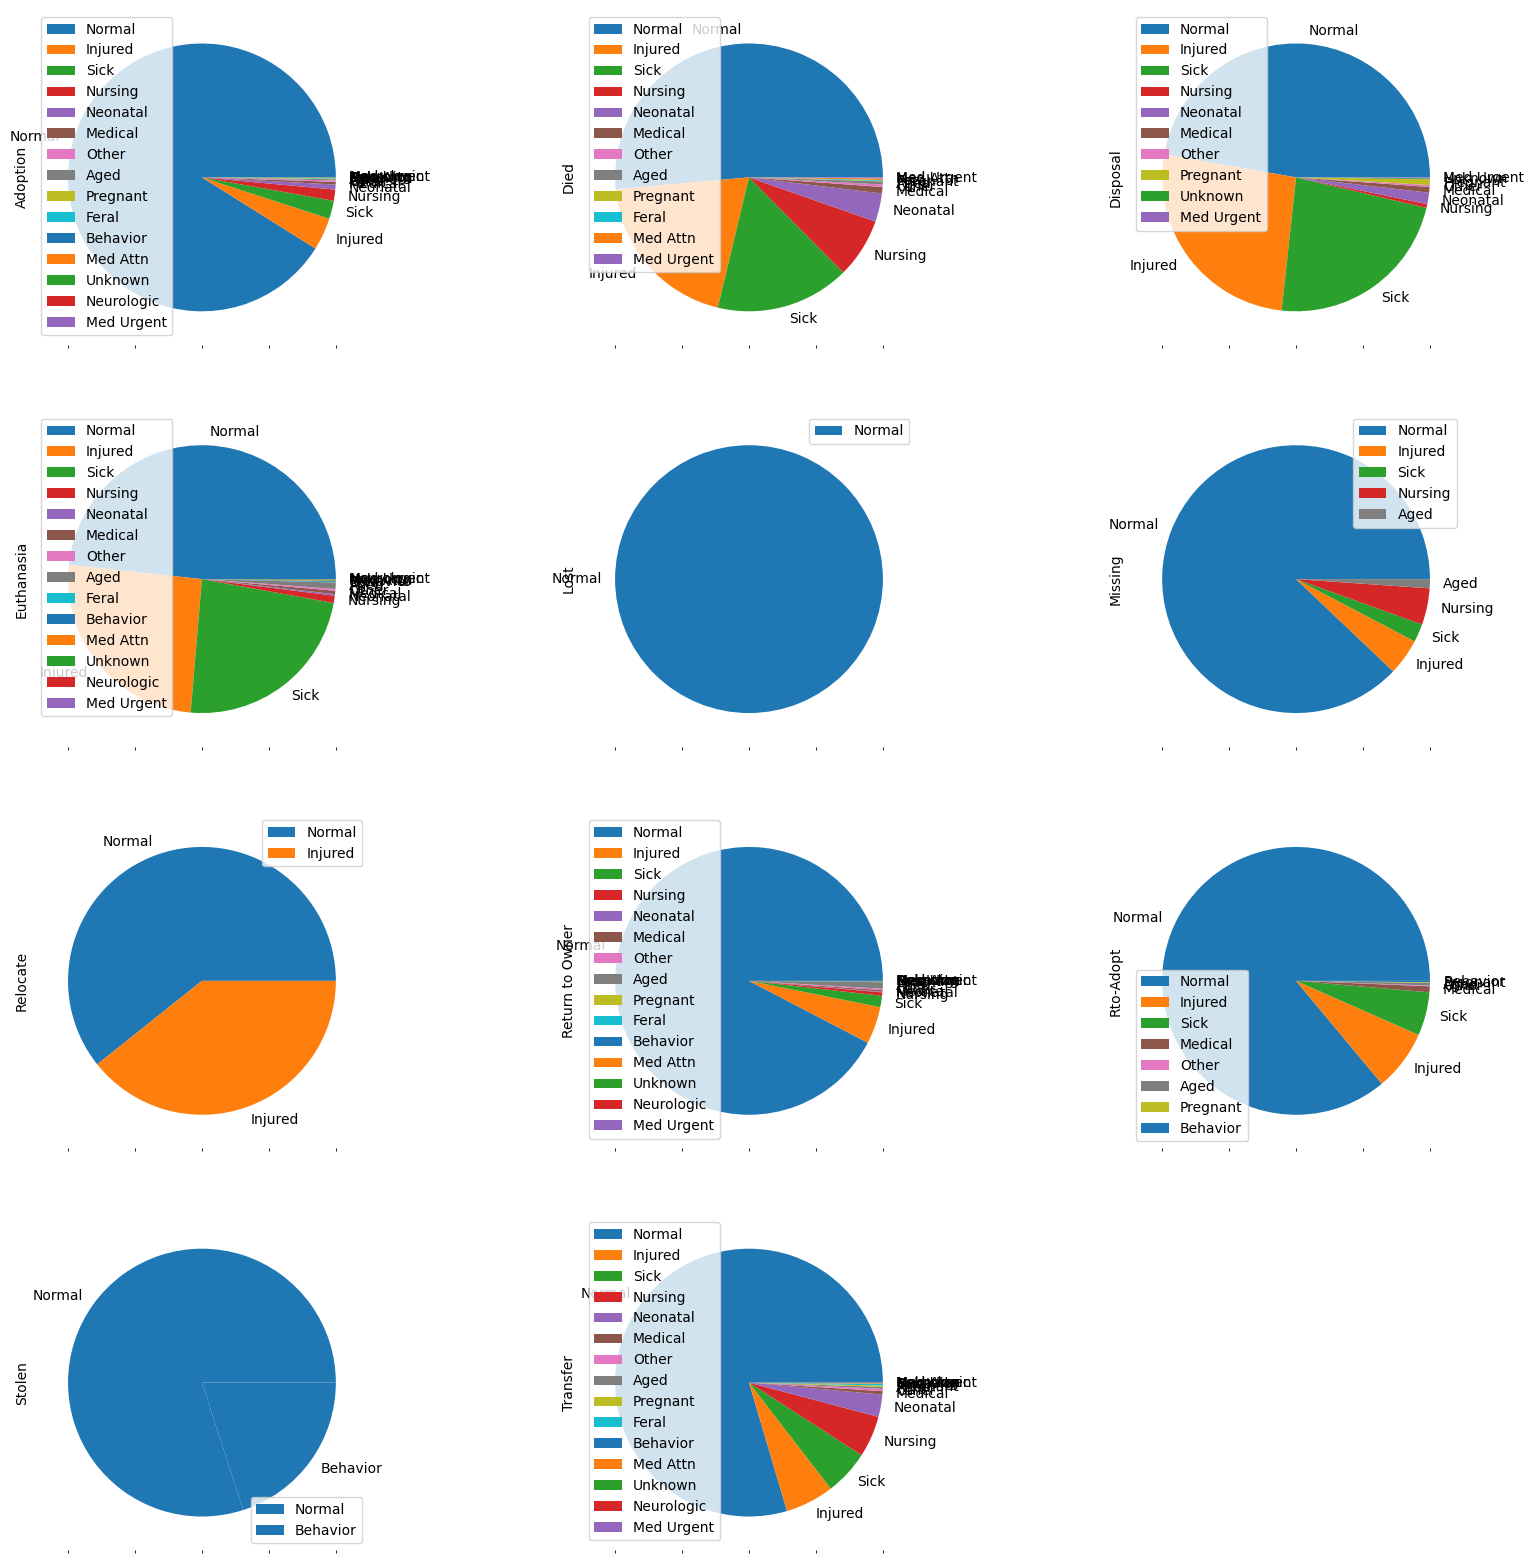

In [21]:
df = cumulatively_categorize(df, columns=["Breed"], num_categories = 10)
show_pie_chart(raw_df, "Intake Condition")

## Feature Engineering

In [22]:
df = raw_df.copy()

def one_hot_encode(df, columns):
    '''
    Take a categorical variable, one-hot encode, and join back into dataframe.
    '''
    for column_name in columns:
        one_hot_encoded = pd.get_dummies(df[column_name], prefix=column_name)
        df = df.drop(column_name, axis='columns')
        df = df.join(one_hot_encoded, on="Animal ID")
    return df


# Breed: bin less common breeds into "Other", one-hot encode
df['Breed'] = df['Breed'].apply(lambda str: str.replace(" Mix", "")) # remove Mix
df = cumulatively_categorize(df, columns=["Breed"], num_categories = 10)
df = one_hot_encode(df, columns=["Breed"])

# Outcome Type: collect Adoption, Return to Owner, Rto-Adopt
def collectAdoption(outcome):
    if(outcome in ["Adoption", "Return to Owner", "Rto-Adopt"]):
        return ("Adoption/RTO")
    else:
        return outcome
df["Outcome Type"] = df["Outcome Type"].apply(collectAdoption)
df = cumulatively_categorize(df, columns=["Outcome Type"],num_categories=4)
df = one_hot_encode(df, columns=["Outcome Type"])

# To drop
to_drop = ["Name", "MonthYear", "Color", "Found Location", "DateTime"]
df = df.drop(columns=to_drop)

# To one-hot encode
to_one_hot_encode = ["Intake Type", "Intake Condition", "Animal Type", "Sex upon Intake"] # experiment
df = cumulatively_categorize(df, columns=to_one_hot_encode)
df = one_hot_encode(df, columns=to_one_hot_encode)


['Domestic Shorthair', 'Pit Bull', 'Labrador Retriever', 'Chihuahua Shorthair', 'German Shepherd', 'Domestic Medium Hair', 'Bat', 'Australian Cattle Dog', 'Domestic Longhair', 'Siamese', 'Siberian Husky']
['Adoption/RTO', 'Transfer', 'Euthanasia', 'Died', 'Disposal']
['Stray', 'Owner Surrender', 'Public Assist']
['Normal', 'Injured']
['Dog', 'Cat']
['Intact Male', 'Intact Female', 'Neutered Male', 'Spayed Female']


In [23]:
df.head()

,Age upon Intake,Breed_Australian Cattle Dog,Breed_Bat,Breed_Chihuahua Shorthair,Breed_Domestic Longhair,Breed_Domestic Medium Hair,Breed_Domestic Shorthair,Breed_German Shepherd,Breed_Labrador Retriever,Breed_Other,...,Intake Condition_Normal,Intake Condition_Other,Animal Type_Cat,Animal Type_Dog,Animal Type_Other,Sex upon Intake_Intact Female,Sex upon Intake_Intact Male,Sex upon Intake_Neutered Male,Sex upon Intake_Other,Sex upon Intake_Spayed Female
Animal ID,,,,,,,,,,,,,,,,,,,,,
A006100_0,6.0,False,False,False,False,False,False,False,False,True,...,True,False,False,True,False,False,False,True,False,False
A006100_1,7.0,False,False,False,False,False,False,False,False,True,...,True,False,False,True,False,False,False,True,False,False
A006100_2,10.0,False,False,False,False,False,False,False,False,True,...,True,False,False,True,False,False,False,True,False,False
A047759_0,10.0,False,False,False,False,False,False,False,False,True,...,True,False,False,True,False,False,False,True,False,False
A134067_0,16.0,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,False,False


In [24]:
print(df.columns)

Index(['Age upon Intake', 'Breed_Australian Cattle Dog', 'Breed_Bat',
       'Breed_Chihuahua Shorthair', 'Breed_Domestic Longhair',
       'Breed_Domestic Medium Hair', 'Breed_Domestic Shorthair',
       'Breed_German Shepherd', 'Breed_Labrador Retriever', 'Breed_Other',
       'Breed_Pit Bull', 'Breed_Siamese', 'Breed_Siberian Husky',
       'Outcome Type_Adoption/RTO', 'Outcome Type_Died',
       'Outcome Type_Disposal', 'Outcome Type_Euthanasia',
       'Outcome Type_Other', 'Outcome Type_Transfer', 'Intake Type_Other',
       'Intake Type_Owner Surrender', 'Intake Type_Public Assist',
       'Intake Type_Stray', 'Intake Condition_Injured',
       'Intake Condition_Normal', 'Intake Condition_Other', 'Animal Type_Cat',
       'Animal Type_Dog', 'Animal Type_Other', 'Sex upon Intake_Intact Female',
       'Sex upon Intake_Intact Male', 'Sex upon Intake_Neutered Male',
       'Sex upon Intake_Other', 'Sex upon Intake_Spayed Female'],
      dtype='object')


In [25]:
# labels_names = ['Outcome Type_Adoption', 'Outcome Type_Died',
#        'Outcome Type_Disposal', 'Outcome Type_Euthanasia',
#        'Outcome Type_Missing', 'Outcome Type_Relocate',
#        'Outcome Type_Return to Owner', 'Outcome Type_Rto-Adopt',
#        'Outcome Type_Transfer',]

labels_names = ['Outcome Type_Died',
       'Outcome Type_Disposal', 'Outcome Type_Euthanasia',
       'Outcome Type_Other', 'Outcome Type_Transfer', 'Outcome Type_Adoption/RTO']
labels = df[labels_names]
features = df.drop(columns=labels_names)
print("labels:",labels.shape)
print("features:",features.shape)
features.head()

labels: (172850, 6)
features: (172850, 28)


,Age upon Intake,Breed_Australian Cattle Dog,Breed_Bat,Breed_Chihuahua Shorthair,Breed_Domestic Longhair,Breed_Domestic Medium Hair,Breed_Domestic Shorthair,Breed_German Shepherd,Breed_Labrador Retriever,Breed_Other,...,Intake Condition_Normal,Intake Condition_Other,Animal Type_Cat,Animal Type_Dog,Animal Type_Other,Sex upon Intake_Intact Female,Sex upon Intake_Intact Male,Sex upon Intake_Neutered Male,Sex upon Intake_Other,Sex upon Intake_Spayed Female
Animal ID,,,,,,,,,,,,,,,,,,,,,
A006100_0,6.0,False,False,False,False,False,False,False,False,True,...,True,False,False,True,False,False,False,True,False,False
A006100_1,7.0,False,False,False,False,False,False,False,False,True,...,True,False,False,True,False,False,False,True,False,False
A006100_2,10.0,False,False,False,False,False,False,False,False,True,...,True,False,False,True,False,False,False,True,False,False
A047759_0,10.0,False,False,False,False,False,False,False,False,True,...,True,False,False,True,False,False,False,True,False,False
A134067_0,16.0,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,False,False


## Data Analysis

### Test/Train Split

In [26]:
from sklearn import *
from sklearn.model_selection import train_test_split
train_size = int(.8*len(features))
test_size = len(features) - train_size
X_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, train_size=train_size, shuffle=False)
print("length of train set: ")
print(len(y_train))
print("length of test set: ")
print(len(y_test))

length of train set: 
138280
length of test set: 
34570


In [27]:
from sklearn import *
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
clfO = DecisionTreeClassifier(criterion='entropy', max_depth=4)
clfO = clfO.fit(X_train, y_train)
y_predict = clfO.predict(x_test)
acc = accuracy_score(y_test, y_predict)
print(acc) # need to see precision

0.6771478160254556


In [28]:
print(tree.export_text(clfO, feature_names=list(features.columns)))

|--- Sex upon Intake_Other <= 0.50
|   |--- Intake Condition_Normal <= 0.50
|   |   |--- Age upon Intake <= 0.07
|   |   |   |--- Age upon Intake <= 0.01
|   |   |   |   |--- class: 1
|   |   |   |--- Age upon Intake >  0.01
|   |   |   |   |--- class: 3
|   |   |--- Age upon Intake >  0.07
|   |   |   |--- Intake Type_Other <= 0.50
|   |   |   |   |--- class: 3
|   |   |   |--- Intake Type_Other >  0.50
|   |   |   |   |--- class: 3
|   |--- Intake Condition_Normal >  0.50
|   |   |--- Animal Type_Dog <= 0.50
|   |   |   |--- Intake Type_Stray <= 0.50
|   |   |   |   |--- class: 3
|   |   |   |--- Intake Type_Stray >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Animal Type_Dog >  0.50
|   |   |   |--- Intake Type_Owner Surrender <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Intake Type_Owner Surrender >  0.50
|   |   |   |   |--- class: 1
|--- Sex upon Intake_Other >  0.50
|   |--- Intake Type_Other <= 0.50
|   |   |--- Age upon Intake <= 0.07
|   |   |   |--- Intake Type

In [29]:
# Use `sklearn.tree.DecisionTreeClassifier` to fit a decision tree classifier on the training set. Use entropy as the split criterion.
from sklearn import *

clf = tree.DecisionTreeClassifier(criterion="entropy")
param_grid={
    "max_depth": [5,10],
    "min_samples_leaf": [5,10],
    "max_features": [5,10],
}
clf = model_selection.GridSearchCV(clf,param_grid=param_grid,cv=5,scoring="accuracy")
clf.fit(X_train,y_train)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 5}
0.7013523286086201


In [30]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
labels = df.iloc[:,13]
clf = GaussianNB()
accs=np.mean(model_selection.cross_val_score(clf, X=features, y=labels,cv=10))
print("Accuracy NB: ")
print(accs.mean())
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = cross_val_predict(clf, features, labels, cv=10)
conf_mat = confusion_matrix(labels, y_pred)
print("Confusion Matrix: ")
print(conf_mat)
print("Classification Report: ")
print(classification_report(labels, y_pred))


Accuracy NB: 
0.7211917847844951
Confusion Matrix: 
[[ 20296  41682]
 [  6510 104362]]
Classification Report: 
              precision    recall  f1-score   support

       False       0.76      0.33      0.46     61978
        True       0.71      0.94      0.81    110872

    accuracy                           0.72    172850
   macro avg       0.74      0.63      0.63    172850
weighted avg       0.73      0.72      0.69    172850



In [31]:
# knn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA
pca = PCA()
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('knn', knn)])
res = cross_val_score(pipe, features, labels, cv=5)
print(res.mean())

0.6665374602256292


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000) # Increased max_iter for convergence

# Perform cross-validation
log_reg_accs = cross_val_score(log_reg, features, labels, cv=10)

print("Accuracy Logistic Regression: ")
print(log_reg_accs.mean())

# Get cross-validated predictions for the confusion matrix and classification report
y_pred_log_reg = cross_val_predict(log_reg, features, labels, cv=10)

print("Confusion Matrix (Logistic Regression): ")
print(confusion_matrix(labels, y_pred_log_reg))

print("Classification Report (Logistic Regression): ")
print(classification_report(labels, y_pred_log_reg))

Accuracy Logistic Regression: 
0.7322823257159387
Confusion Matrix (Logistic Regression): 
[[ 22113  39865]
 [  6410 104462]]
Classification Report (Logistic Regression): 
              precision    recall  f1-score   support

       False       0.78      0.36      0.49     61978
        True       0.72      0.94      0.82    110872

    accuracy                           0.73    172850
   macro avg       0.75      0.65      0.65    172850
weighted avg       0.74      0.73      0.70    172850



## Results

## Results Summary

Here's a summary of the model performance based on the analysis:

- **Decision Tree Classifier (initial):** Achieved an accuracy of {{acc}}. The decision tree structure provides insights into the features most influential in predicting the outcome.

- **Decision Tree Classifier (tuned with GridSearchCV):** The best parameters found were `max_depth: {{clf.best_params_['max_depth']}}`, `max_features: {{clf.best_params_['max_features']}}`, and `min_samples_leaf: {{clf.best_params_['min_samples_leaf']}}`, resulting in a cross-validation accuracy of {{clf.best_score_}}.

- **Naive Bayes (GaussianNB):** Achieved a cross-validation accuracy of {{accs.mean()}}. The classification report and confusion matrix provide more detailed performance metrics for each class:

{{conf_mat}}

{{classification_report(labels, y_pred)}}

- **K-Nearest Neighbors (KNN) with PCA and StandardScaler:** Achieved a cross-validation accuracy of {{res.mean()}}.

Based on these results, the Naive Bayes model appears to have the highest accuracy among the models tested so far.

### Logistic Regression